In [25]:
import yfinance as yf
import pandas as pd
import numpy as np

def fetch_data(tickers, start="2020-01-01", end="2025-12-31"):
    data = yf.download(tickers, start=start, end=end, group_by='ticker', auto_adjust=True)
    
    # If multiple tickers
    if isinstance(tickers, list):
        close_data = pd.DataFrame({ticker: data[ticker]["Close"] for ticker in tickers})
    else:  # Single ticker
        close_data = data["Close"].to_frame(name=tickers)
    
    return close_data.dropna()

def compute_features(prices):
    returns = prices.pct_change().dropna()
    vol = returns.std()
    sharpe = (returns.mean() / returns.std()) * np.sqrt(252)  # Annualized Sharpe ratio
    drawdown = (prices / prices.cummax() - 1).min()
    features = pd.DataFrame({
        'volatility': vol,
        'sharpe': sharpe,
        'max_drawdown': drawdown
    })
    return features

def label_risk(features):
    risk = []
    for i, row in features.iterrows():
        if row['volatility'] > 0.03 and row['sharpe'] < 0.5:
            risk.append("high")
        elif row['volatility'] < 0.015 and row['sharpe'] > 1.0:
            risk.append("low")
        else:
            risk.append("medium")
    features['risk'] = risk
    return features

if __name__ == "__main__":
    tickers = [
        # Technology
        "AAPL", "MSFT", "GOOG", "NVDA", "ADBE", "CRM", "AMD", "INTC", "AVGO", "ORCL", 
        # Communication Services
        "META", "NFLX", "DIS", "VZ", "T", "TMUS", "CHTR", "WBD", "PARA",
        # Consumer Discretionary
        "TSLA", "AMZN", "MCD", "NKE", "HD", "LOW", "SBUX", "TJX", "ROST", "MAR",
        # Consumer Staples
        "PG", "KO", "PEP", "WMT", "COST", "MDLZ", "CL", "KHC", "KR", "TAP",
        # Financials
        "JPM", "BAC", "GS", "MS", "C", "WFC", "SCHW", "USB", "TFC", "PGR",
        # Health Care
        "UNH", "JNJ", "PFE", "MRK", "LLY", "ABT", "TMO", "CVS", "CI", "BMY",
        # Industrials
        "GE", "UPS", "FDX", "MMM", "BA", "CAT", "DE", "LMT", "NOC", "ETN",
        # Energy
        "XOM", "CVX", "COP", "PSX", "SLB", "EOG", "MPC", "VLO", "HES", "BKR",
        # Materials
        "DOW", "LIN", "NEM", "FCX", "APD", "DD", "ALB", "EMN", "MLM", "VMC",
        # Utilities
        "NEE", "DUK", "SO", "AEP", "EXC", "D", "XEL", "PEG", "SRE", "WEC",
        # Real Estate
        "PLD", "AMT", "CCI", "EQIX", "SPG", "O", "VTR", "AVB", "EQR", "DLR"
    ]
    data = fetch_data(tickers)
    features = compute_features(data)
    labeled = label_risk(features)
    labeled.to_csv("labeled_features.csv")


[*********************100%***********************]  109 of 109 completed


In [26]:
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd

data = pd.read_csv("labeled_features.csv")
X = data[["volatility", "sharpe", "max_drawdown"]]
y = LabelEncoder().fit_transform(data["risk"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train)
clf = SVC(kernel='rbf', class_weight='balanced')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))


     volatility    sharpe  max_drawdown
33     0.015244  1.071145     -0.314024
55     0.017998  0.303284     -0.409543
69     0.021269  0.533168     -0.550049
28     0.024575  0.482839     -0.608443
40     0.022279  0.391330     -0.489468
..          ...       ...           ...
71     0.027507  0.442707     -0.656582
14     0.016656  0.356780     -0.394291
92     0.015393  0.372880     -0.329052
51     0.017148  0.024110     -0.589620
102    0.019501  0.384851     -0.417680

[76 rows x 3 columns]
              precision    recall  f1-score   support

           0       0.25      0.50      0.33         2
           1       0.97      0.90      0.93        31

    accuracy                           0.88        33
   macro avg       0.61      0.70      0.63        33
weighted avg       0.92      0.88      0.90        33



In [27]:
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import QuantumKernel
from sklearn.svm import SVC
from qiskit.utils import QuantumInstance
from qiskit import Aer
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report

data = pd.read_csv("labeled_features.csv")
X = data[["volatility", "sharpe", "max_drawdown"]]
y = LabelEncoder().fit_transform(data["risk"])

# Reduce dimensions
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=42)

feature_map = ZZFeatureMap(feature_dimension=2, reps=2)
quantum_instance = QuantumInstance(Aer.get_backend('statevector_simulator'), shots=1024)

qkernel = QuantumKernel(feature_map=feature_map, quantum_instance=quantum_instance)
kernel_train = qkernel.evaluate(x_vec=X_train)
kernel_test = qkernel.evaluate(x_vec=X_test, y_vec=X_train)

qsvc = SVC(kernel='precomputed', class_weight='balanced')
qsvc.fit(kernel_train, y_train)
y_pred = qsvc.predict(kernel_test)

print(classification_report(y_test, y_pred))


C:\Users\hussa\AppData\Local\Temp\ipykernel_44404\2201256677.py:23: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(Aer.get_backend('statevector_simulator'), shots=1024)


              precision    recall  f1-score   support

           0       0.25      0.50      0.33         2
           1       0.97      0.90      0.93        31

    accuracy                           0.88        33
   macro avg       0.61      0.70      0.63        33
weighted avg       0.92      0.88      0.90        33



<Figure size 1200x1000 with 0 Axes>

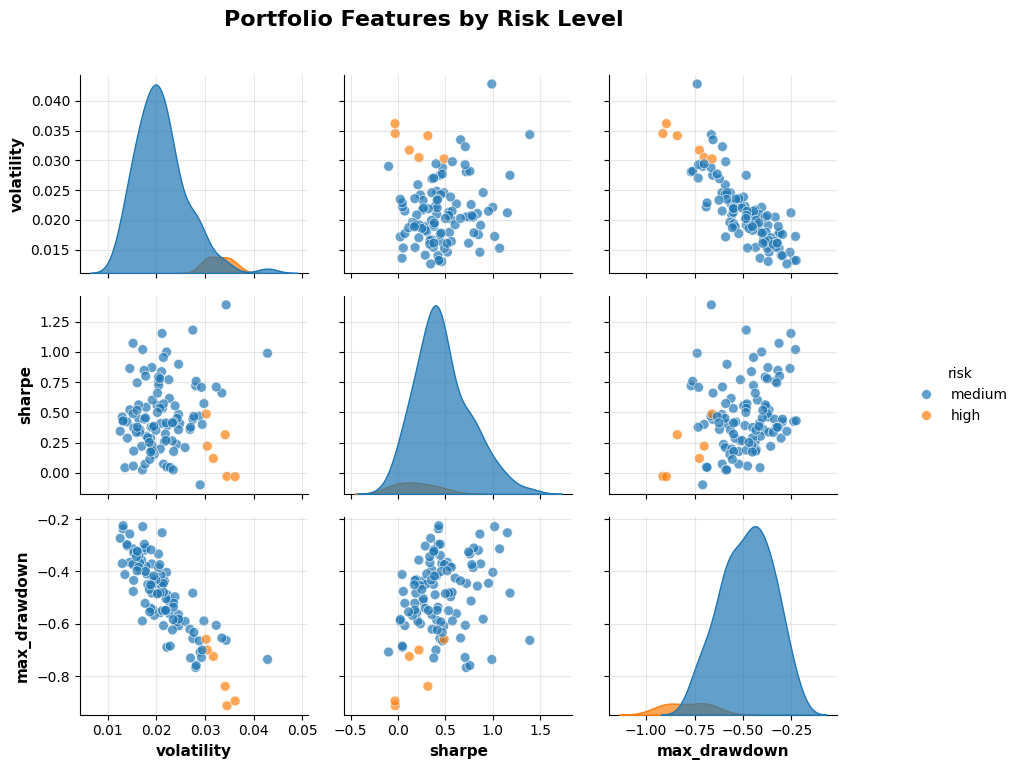

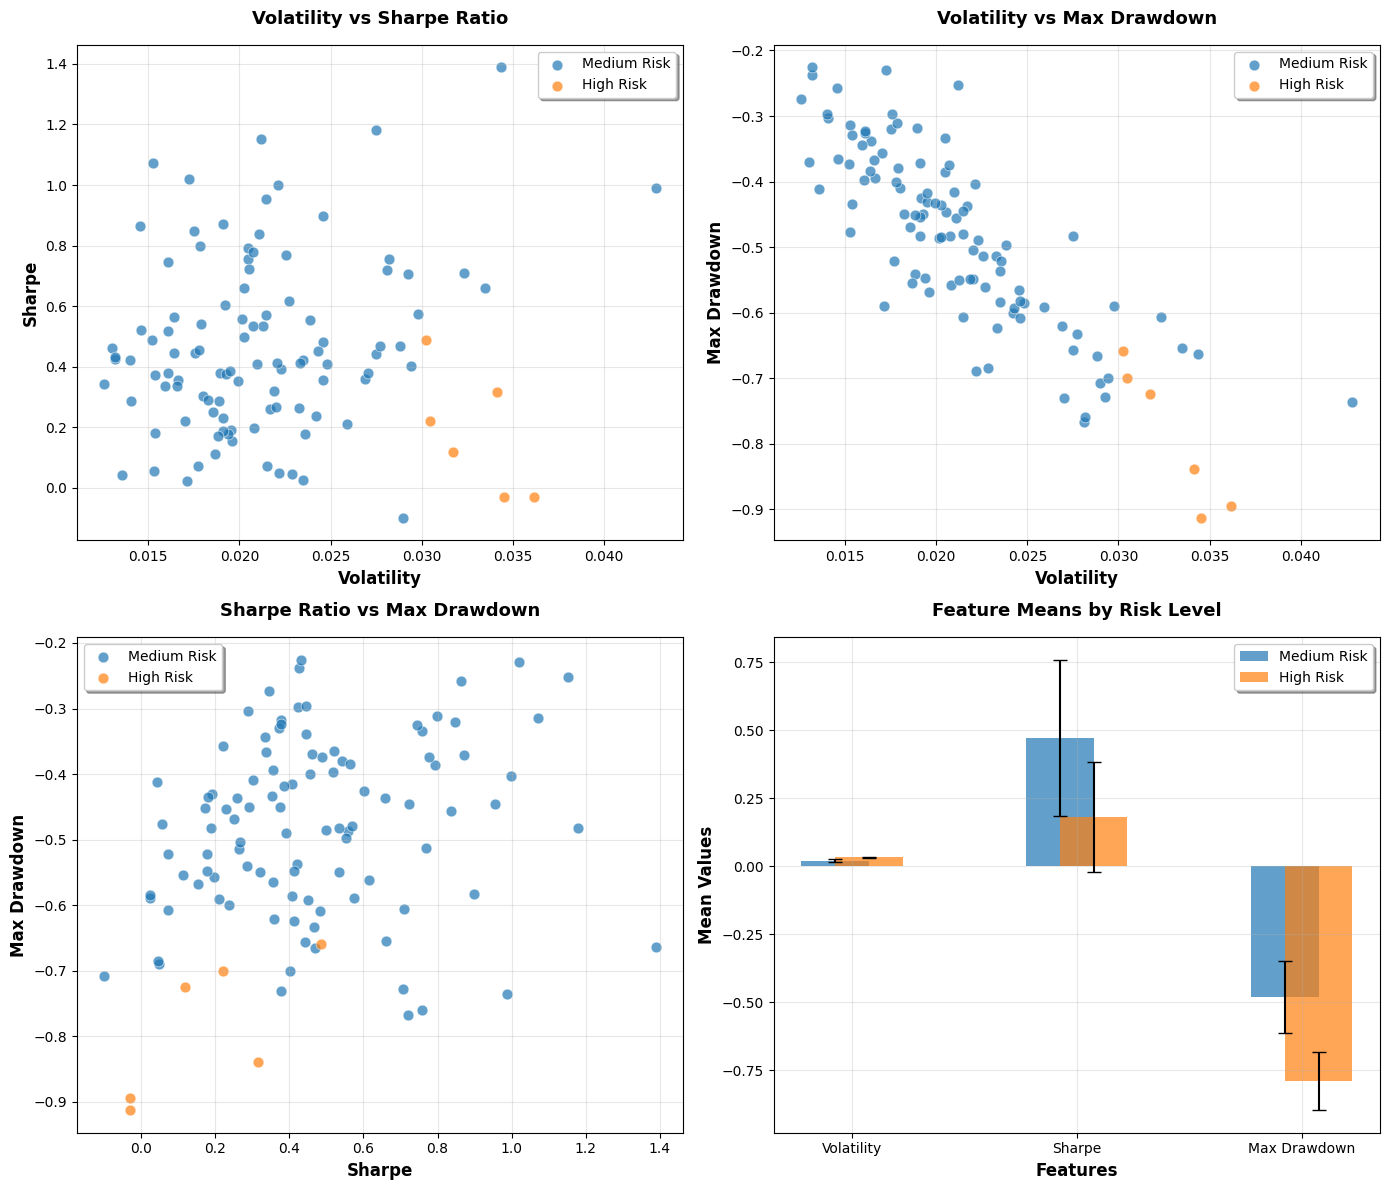

C:\Users\hussa\AppData\Local\Temp\ipykernel_44404\991394395.py:116: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='risk', y=feature, ax=axes[i],
C:\Users\hussa\AppData\Local\Temp\ipykernel_44404\991394395.py:125: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Medium Risk', 'High Risk'])
C:\Users\hussa\AppData\Local\Temp\ipykernel_44404\991394395.py:116: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='risk', y=feature, ax=axes[i],
C:\Users\hussa\AppData\Local\Temp\ipykernel_44404\991394395.py:125: UserWarning: set_ticklabels() should only be used with a fixed

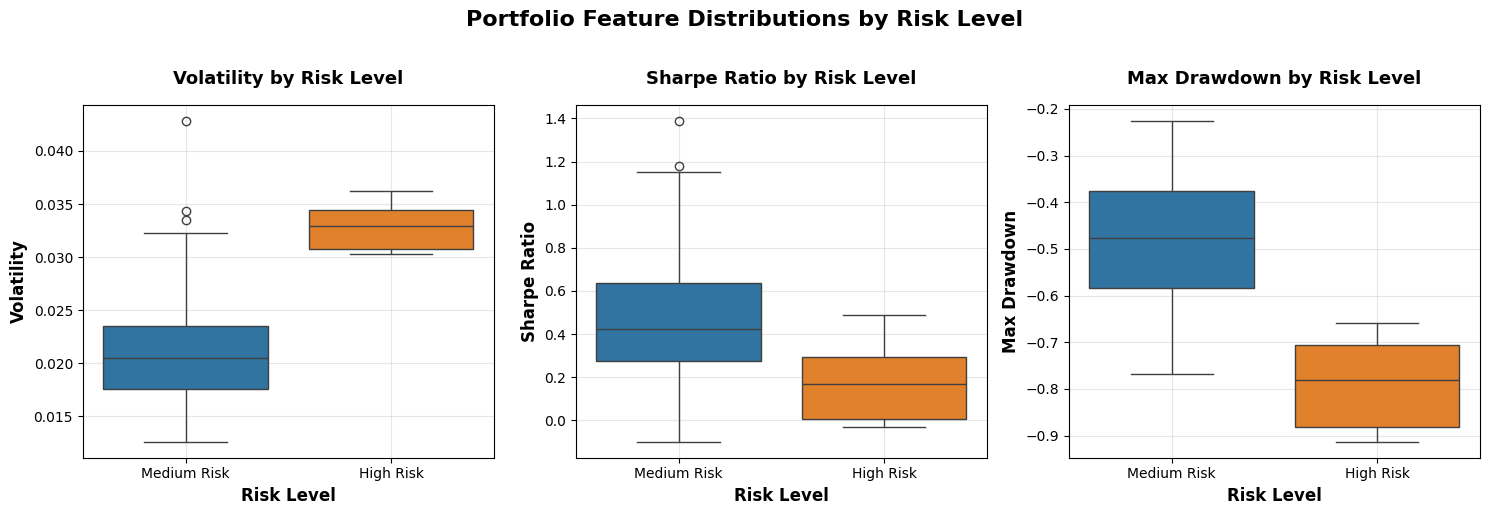

All plots generated successfully!

Dataset Summary:
Total samples: 109
Risk distribution: {'medium': 103, 'high': 6}

Feature ranges:
volatility: 0.0126 to 0.0428
sharpe: -0.0987 to 1.3886
max_drawdown: -0.9132 to -0.2257


In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load data
data = pd.read_csv("labeled_features.csv")

# Set up the plotting style
plt.style.use('default')
sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)


# Method 1: Simple but effective pairplot
plt.figure(figsize=(12, 10))
g = sns.pairplot(
    data, 
    hue='risk',
    diag_kind='kde',
    plot_kws={'alpha': 0.7, 's': 50},
    diag_kws={'alpha': 0.7}
)

# Add title properly positioned
# Move legend outside the plot area to the right
g._legend.set_bbox_to_anchor((1.05, 0.5))
g._legend.set_loc('center left')

g.fig.suptitle("Portfolio Features by Risk Level", y=1.02, fontsize=16, fontweight='bold')



# Improve axis labels
for ax in g.axes.flat:
    ax.set_xlabel(ax.get_xlabel(), fontsize=11, fontweight='bold')
    ax.set_ylabel(ax.get_ylabel(), fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("plots/simple_pairplot.png", dpi=300, bbox_inches='tight')
plt.show()

# Method 2: Individual scatter plots for better control
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Define feature pairs and labels
feature_pairs = [
    ('volatility', 'sharpe', 'Volatility vs Sharpe Ratio'),
    ('volatility', 'max_drawdown', 'Volatility vs Max Drawdown'),
    ('sharpe', 'max_drawdown', 'Sharpe Ratio vs Max Drawdown')
]

colors = {'medium': '#1f77b4', 'high': '#ff7f0e'}
risk_labels = {'medium': 'Medium Risk', 'high': 'High Risk'}



# Create scatter plots
for i, (x_col, y_col, title) in enumerate(feature_pairs):
    row, col = i // 2, i % 2
    ax = axes[row, col]
    
    for risk_level in data['risk'].unique():
        subset = data[data['risk'] == risk_level]
        ax.scatter(subset[x_col], subset[y_col], 
                  alpha=0.7, s=60, 
                  color=colors.get(risk_level, 'gray'),
                  label=risk_labels.get(risk_level, risk_level),
                  edgecolors='white', linewidth=0.5)
    
    ax.set_xlabel(x_col.replace('_', ' ').title(), fontsize=12, fontweight='bold')
    ax.set_ylabel(y_col.replace('_', ' ').title(), fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=13, fontweight='bold', pad=15)
    ax.grid(True, alpha=0.3)
    ax.legend(frameon=True, fancybox=True, shadow=True)

# Create distribution comparison in the last subplot
axes[1, 1].clear()
features = ['volatility', 'sharpe', 'max_drawdown']
x_pos = range(len(features))

for i, risk_level in enumerate(data['risk'].unique()):
    subset = data[data['risk'] == risk_level]
    means = [subset[f].mean() for f in features]
    stds = [subset[f].std() for f in features]
    
    offset = 0.15 * (i - 0.5)  # Offset bars
    axes[1, 1].bar([x + offset for x in x_pos], means, 
                   width=0.3, alpha=0.7, 
                   color=colors.get(risk_level, 'gray'),
                   label=risk_labels.get(risk_level, risk_level),
                   yerr=stds, capsize=5)

axes[1, 1].set_xlabel('Features', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Mean Values', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Feature Means by Risk Level', fontsize=13, fontweight='bold', pad=15)
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels([f.replace('_', ' ').title() for f in features])
axes[1, 1].legend(frameon=True, fancybox=True, shadow=True)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("plots/detailed_scatter_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

# Method 3: Box plots for distribution comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

features = ['volatility', 'sharpe', 'max_drawdown']
feature_labels = {
    'volatility': 'Volatility',
    'sharpe': 'Sharpe Ratio', 
    'max_drawdown': 'Max Drawdown'
}

for i, feature in enumerate(features):
    sns.boxplot(data=data, x='risk', y=feature, ax=axes[i], 
                palette=['#1f77b4', '#ff7f0e'])
    axes[i].set_title(f'{feature_labels[feature]} by Risk Level', 
                     fontsize=13, fontweight='bold', pad=15)
    axes[i].set_xlabel('Risk Level', fontsize=12, fontweight='bold')
    axes[i].set_ylabel(feature_labels[feature], fontsize=12, fontweight='bold')
    axes[i].grid(True, alpha=0.3)
    
    # Customize x-axis labels
    axes[i].set_xticklabels(['Medium Risk', 'High Risk'])

plt.suptitle('Portfolio Feature Distributions by Risk Level', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig("plots/boxplot_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

print("All plots generated successfully!")
print("\nDataset Summary:")
print(f"Total samples: {len(data)}")
print(f"Risk distribution: {data['risk'].value_counts().to_dict()}")
print(f"\nFeature ranges:")
for feature in ['volatility', 'sharpe', 'max_drawdown']:
    print(f"{feature}: {data[feature].min():.4f} to {data[feature].max():.4f}")

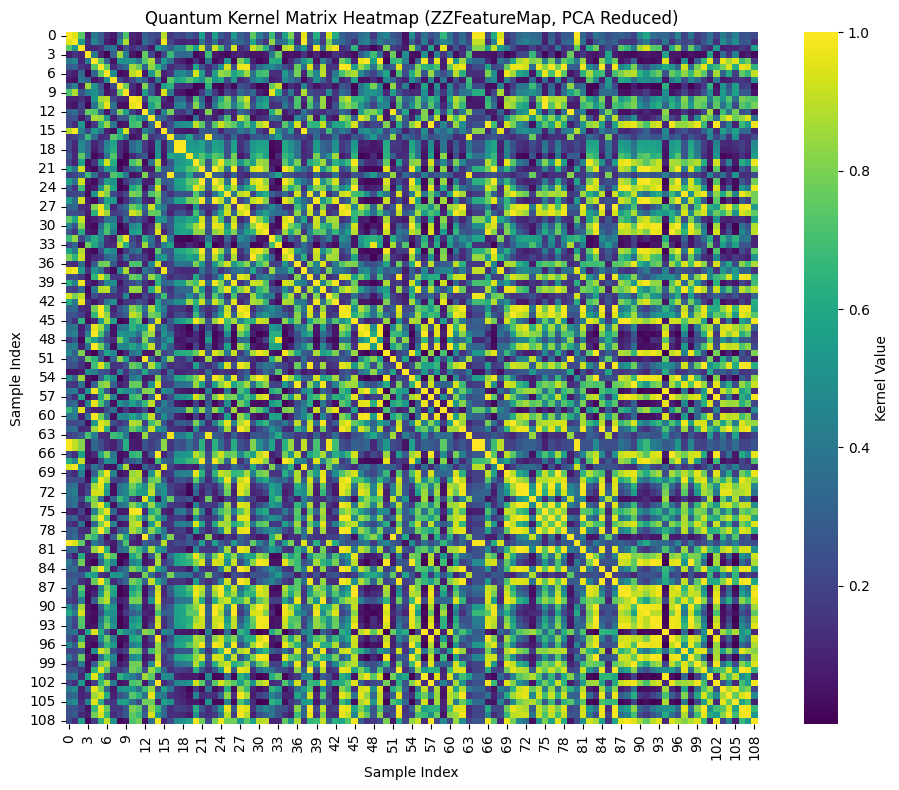

In [29]:
kernel_matrix = qkernel.evaluate(x_vec=X_reduced)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(kernel_matrix, cmap="viridis", square=True, cbar_kws={'label': 'Kernel Value'})
plt.title("Quantum Kernel Matrix Heatmap (ZZFeatureMap, PCA Reduced)")
plt.xlabel("Sample Index")
plt.ylabel("Sample Index")
plt.tight_layout()
plt.show()